In [1]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
%matplotlib inline
from helpers import *
from datetime import datetime
from scipy.sparse import dia_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import bicgstab
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import lsqr
%load_ext autotime
from scipy.ndimage import imread
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

with open("hyperParams.json") as f:
    instanceParams = json.load(f)

baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate

photoAlpha = instanceParams["photoParams"]["robustness"]
photoBeta = instanceParams["photoParams"]["scale"]
wei = instanceParams["smoothParams"]["weight"]

time: 7.65 ms


In [3]:
flow = np.zeros((480, 854, 2))
gt = mpimg.imread('../example_data/data/DAVIS/Annotations/480p/train/00023.png')
#gt = np.zeros((480, 854))

time: 37.8 ms


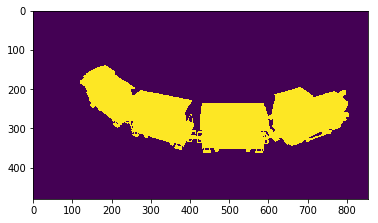

time: 211 ms


In [4]:
plt.imshow(gt)

In [5]:
flow = np.expand_dims(flow, 0)
gt = np.expand_dims(np.expand_dims(gt, 0), -1)

flow = tf.cast(flow, tf.float32)
gt = tf.cast(gt, tf.float32)
flow = tf.Variable(flow)

time: 51.6 ms


In [6]:
img0 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/train/00023.jpg"), channels=3, dtype=tf.uint8)
img1 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/train/00024.jpg"), channels=3, dtype=tf.uint8)

rgb0 = (tf.cast(img0, tf.float32) - [[[[0,0,0]]]]) / 255.0
rgb1 = (tf.cast(img1, tf.float32) - [[[[0,0,0]]]]) / 255.0

time: 16.7 ms


In [7]:
def mse_loss(f1, f2):
    return tf.reduce_sum(tf.square(f1 - f2), axis=-1, keep_dims=True)

time: 8.39 ms


In [8]:
kernel = tf.transpose(tf.constant([[[[0,-1,0],
                                     [0,1,0],
                                     [0,0,0]]],
                                   [[[0,0,0],
                                     [0,1,-1],
                                     [0,0,0]]],
                                   [[[0,0,0],
                                     [0,1,0],
                                     [0,-1,0]]],
                                   [[[0,0,0],
                                     [-1,1,0],
                                     [0,0,0]]]],
                                  dtype=tf.float32),perm=[3,2,1,0])

time: 27.5 ms


In [9]:
w = 1
GT_MASKS = []
for i in range(w):
    GT_MASKS.append(1 - tf.square(tf.nn.atrous_conv2d(gt, kernel, rate=i+1, padding='SAME')))

time: 52.7 ms


In [10]:
normalizer = tf.zeros((1, 480, 854, 2))

multiplier_masks = []
for i in range(w):
    multiplier_masks.append([])

for i in range(w):
    j = i + 1
    gt_mask = GT_MASKS[i]

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,:,j:854,0],
                           tf.zeros((1, 480, j), dtype=tf.float32)], axis=2), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, j, 854), dtype=tf.float32),
                           gt_mask[:,0:(480-j),:,1]], axis=1), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, 480, j), dtype=tf.float32),
                           gt_mask[:,:,0:(854-j),2]], axis=2), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,j:480,:,3],
                           tf.zeros((1, j, 854), dtype=tf.float32)], axis=1), axis=-1), (1, 1, 1, 2)))

    normalizer += multiplier_masks[i][0] + multiplier_masks[i][1] + multiplier_masks[i][2] + multiplier_masks[i][3]

# Remove 0's in normalizer
normalizer += 4 * w * tf.cast(tf.equal(normalizer, 0), dtype=tf.float32)
normalizer.shape

TensorShape([Dimension(1), Dimension(480), Dimension(854), Dimension(2)])

time: 77 ms


In [11]:
m0 = multiplier_masks[0][0].eval(session=tf.Session())[0,:,:,0]
m1 = multiplier_masks[0][1].eval(session=tf.Session())[0,:,:,0]
m2 = multiplier_masks[0][2].eval(session=tf.Session())[0,:,:,0]
m3 = multiplier_masks[0][3].eval(session=tf.Session())[0,:,:,0]

m4 = normalizer.eval(session=tf.Session())[0,:,:,0]

time: 1.42 s


In [12]:
H, W = 480, 854
nelem = H * W
data0 = np.array([
    np.concatenate((np.array([0]), -m0.ravel()))[:nelem],
    np.concatenate((-m1.ravel()[W:], np.repeat(0, W)))[:nelem],
    np.concatenate((-m2.ravel()[1:], np.array([0])))[:nelem],
    np.concatenate((np.repeat(0, W), -m3.ravel()))[:nelem]
])
offset0 = [1, -W, -1, W]

A0 = dia_matrix((data0, offset0), shape=(nelem, nelem))

# A = A0 + dia_matrix(((gamma + m4).ravel(), 0), shape=(nelem, nelem))

time: 18.7 ms


In [13]:
def ls_solve(flow, gamma):
    H, W = 480, 854
    nelem = H * W
    shp = (nelem, nelem)

    A = A0 + dia_matrix(((gamma[0,:,:,0] + m4).ravel(), 0), shape=(nelem, nelem))
    u = bicgstab(A, (flow[0,:,:,0] * gamma[0,:,:,0]).ravel())[0].reshape((H, W))
    v = bicgstab(A, (flow[0,:,:,1] * gamma[0,:,:,0]).ravel())[0].reshape((H, W))

    return np.expand_dims(np.dstack([u, v]), 0).astype(np.float32)

time: 35.4 ms


In [14]:
# import cv2
# # fhat = tf.expand_dims(tf.stack([tf.ones((480, 854)) * -2.47, tf.ones((480, 854)) * -1.58], axis=-1), 0)
# # fhat = tf.zeros_like(flow)
# f = cv2.resize(np.load('/home/y788zhang/network_init.npy'), (854, 480)) * 2
# fhat = tf.expand_dims(tf.cast(f, tf.float32), 0)

time: 12.8 ms


In [15]:
gammaTensor = tf.placeholder(tf.float32,shape=[1, 480, 854, 1])
golTensor = tf.placeholder(tf.float32,shape=[1, 480, 854, 1])

def adm_loss_fn(flow, gol, gamma):
    pLoss = photoLoss(flow, rgb0, rgb1, photoAlpha, photoBeta)
    actual_smooth_loss = asymmetricSmoothLoss(flow, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
    actual_smooth_loss = tf.stop_gradient(actual_smooth_loss)
    flow_copy = flow * 1.0
    flow_copy = tf.stop_gradient(flow_copy)
    fhat = tf.py_func(ls_solve, [flow_copy, gol], tf.float32)
    # fhat = tf.zeros_like(flow)
    sLoss = asymmetricSmoothLoss(fhat, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
    mLoss = mse_loss(flow, fhat)

    return pLoss, sLoss, gamma * mLoss, actual_smooth_loss, fhat

time: 39.6 ms


In [16]:
photo_loss, smooth_loss, eucl_loss, as_loss, fhat = adm_loss_fn(flow, golTensor, gammaTensor)
adm_loss = photo_loss + eucl_loss

Instructions for updating:
keep_dims is deprecated, use keepdims instead
time: 1.57 s


In [17]:
sGrad = tf.gradients(smooth_loss, fhat)
pGrad = tf.gradients(photo_loss, flow)
mGrad = tf.gradients(eucl_loss, flow)
tGrad = tf.gradients(adm_loss, flow)

time: 414 ms


In [18]:
solver, solver_op, learningRateTensor = attachSolver(adm_loss)
# learningRateTensor = tf.placeholder(tf.float32, shape=[])
# solver = tf.train.GradientDescentOptimizer(learning_rate=learningRateTensor)
# solver_op = solver.minimize(adm_loss)

time: 195 ms


In [21]:
itr = 5000
ada_gol = np.linspace(10, 20, itr + 1)

lambda_ = 200
mygamma = 2 * np.ones((1, 480, 854, 1))
mygol = mygamma / lambda_

time: 5 ms


In [ ]:
init = tf.global_variables_initializer()
mLosses, sLosses, pLosses, asLosses = [], [], [], []
tGrads, sGrads, pGrads, mGrads = [], [], [], []
flows, flow_props = [], []

print_freq = 10
with tf.Session() as sess:
    sess.run(init)
    for i in range(1, itr + 2):
        feed_dict = {
            learningRateTensor: 1,
            gammaTensor: mygamma, # 100000.0,
            golTensor: mygol # 10.0
        }
        _, s, p, m, f, fp, asl, mg, pg = sess.run([solver_op,
                                      smooth_loss,
                                      photo_loss,
                                      eucl_loss,
                                      flow,
                                      fhat,
                                      as_loss,
                                      mGrad,
                                      pGrad], feed_dict = feed_dict)
        mygamma += 10.0 * m / mygamma
        mygol = mygamma / lambda_

        if i % print_freq == 5:
            print(i)
            print "Mean gamma: %f" % float(np.mean(mygamma))
            flows.append(deepcopy(f[0]))
            flow_props.append(deepcopy(fp[0]))
            sLosses.append(np.mean(s))
            asLosses.append(np.mean(asl))
            pLosses.append(np.mean(p))
            mLosses.append(deepcopy(m))
            mGrads.append(deepcopy(mg[0]))
            pGrads.append(deepcopy(pg[0]))
            print "Photo loss: %f" % float(pLosses[-1])
            print "Smooth loss after LS: %f" % sLosses[-1]
            print "Smooth loss from \"network\": %f" % np.mean(asl)

5
Mean gamma: 127.090118
Photo loss: 986.961914
Smooth loss after LS: 0.628245
Smooth loss from "network": 18.089241
15
Mean gamma: 287.973870
Photo loss: 623.223755
Smooth loss after LS: 1.545642
Smooth loss from "network": 8.175164
25
Mean gamma: 343.191129
Photo loss: 441.721436
Smooth loss after LS: 1.239237
Smooth loss from "network": 4.896275
35
Mean gamma: 374.302283
Photo loss: 356.408112
Smooth loss after LS: 1.071388
Smooth loss from "network": 3.592162
45
Mean gamma: 396.195204
Photo loss: 312.652069
Smooth loss after LS: 1.012981
Smooth loss from "network": 3.052741
55
Mean gamma: 413.810998
Photo loss: 293.261932
Smooth loss after LS: 0.996982
Smooth loss from "network": 2.799706
65
Mean gamma: 429.103409
Photo loss: 284.610748
Smooth loss after LS: 0.996876
Smooth loss from "network": 2.666552
75
Mean gamma: 442.948535
Photo loss: 280.399597
Smooth loss after LS: 1.006377
Smooth loss from "network": 2.592733
85
Mean gamma: 455.782604
Photo loss: 278.446838
Smooth loss aft

(array([1.70000e+01, 1.80000e+01, 2.20000e+01, 2.14000e+02, 1.32030e+04,
        4.07917e+05, 3.52345e+05, 2.98870e+04, 1.57500e+04, 4.67000e+02]),
 array([-16.120504 , -13.492983 , -10.86546  ,  -8.237939 ,  -5.610417 ,
         -2.982895 ,  -0.355373 ,   2.2721488,   4.8996706,   7.5271926,
         10.154715 ], dtype=float32),
 <a list of 10 Patch objects>)

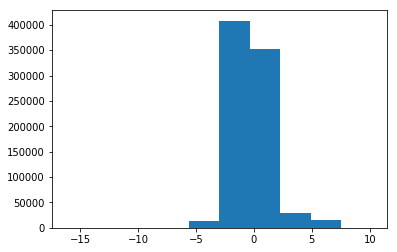

time: 176 ms


In [23]:
plt.hist(flows[-1].ravel())

In [33]:
f1 = tf.cast(np.expand_dims(flows[1], 0), tf.float32)
hi = asymmetricSmoothLoss(f1, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
hi = hi.eval(session=tf.Session())

time: 6.99 ms


max flow: 158010.0781
flow range:
u = -146054.016 .. 75392.016
v = -158010.031 .. 66628.016


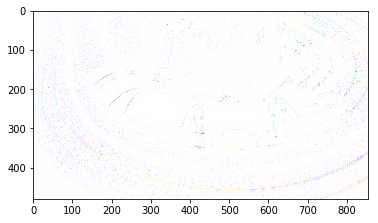

time: 382 ms


In [51]:
plt.imshow(flow_to_image(pGrads[0][0]))

max flow: 0.0000
flow range:
u = 0.000 .. 0.000
v = 0.000 .. 0.000


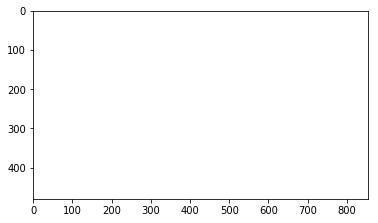

time: 287 ms


In [50]:
plt.imshow(flow_to_image(mGrads[0][0]))

(array([3.43974e+05, 1.15000e+02, 3.00000e+01, 0.00000e+00, 0.00000e+00,
        4.72990e+04, 0.00000e+00, 4.10000e+01, 9.30000e+01, 4.28288e+05]),
 array([-0.10000002, -0.08000001, -0.06000001, -0.04000001, -0.02      ,
         0.        ,  0.02      ,  0.04000001,  0.06000001,  0.08000001,
         0.10000002], dtype=float32),
 <a list of 10 Patch objects>)

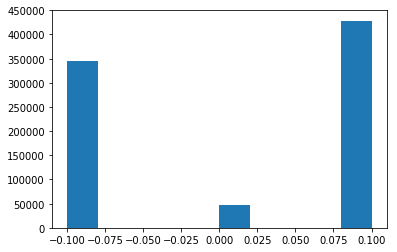

time: 189 ms


In [32]:
plt.hist(flows[1].ravel(), bins=10)

In [40]:
from scipy.ndimage.filters import convolve
def smooth_loss(uv, gt):
    u, v = uv[:,:,0], uv[:,:,1]
    gt_kernels = [[[0,0,0],
               [0,1,-1],
               [0,0,0]],
              [[0,-1,0],
               [0,1,0],
               [0,0,0]],
              [[0,0,0],
               [-1,1,0],
               [0,0,0]],
              [[0,0,0],
               [0,1,0],
               [0,-1,0]]]
    
    udx = convolve(u, gt_kernels[0]) * (1 - convolve(gt, gt_kernels[0]) ** 2)
    udy = convolve(u, gt_kernels[1]) * (1 - convolve(gt, gt_kernels[1]) ** 2)
    vdx = convolve(v, gt_kernels[0]) * (1 - convolve(gt, gt_kernels[0]) ** 2)
    vdy = convolve(v, gt_kernels[1]) * (1 - convolve(gt, gt_kernels[1]) ** 2)

    return np.mean(udx**2 + udy**2 + vdx**2 + vdy**2)

time: 12.6 ms


max flow: 7.5576
flow range:
u = -3.537 .. 5.610
v = -5.493 .. 5.464


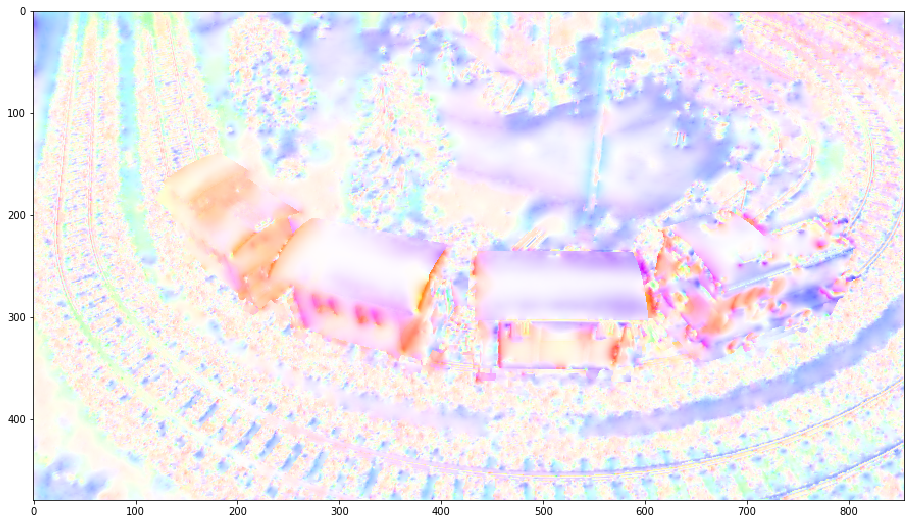

time: 984 ms


In [26]:
plt.figure(figsize=(16, 9))
plt.imshow(flow_to_image(flows[50]))

In [23]:
im1 = imread("../example_data/data/DAVIS/JPEGImages/480p/train/00023.jpg")[12:-12,11:-11,:].astype(np.float32)
im2 = imread("../example_data/data/DAVIS/JPEGImages/480p/train/00024.jpg")[12:-12,11:-11,:].astype(np.float32)

time: 34.2 ms


In [25]:
from helpers import photo_loss as pl
pl(im1, im2, flows[-1][12:-12,11:-11,:])

249.66954

time: 233 ms


In [26]:
fh = fhat.eval(session=tf.Session())[0][12:-12,11:-11,:]

time: 60.5 ms


In [36]:
np.mean(((np.round(flows[-1][12:-12,11:-11,:]) - fh) / 2) ** 2)

0.040914755

time: 11.2 ms


max flow: 9.5249
flow range:
u = -3.457 .. 9.094
v = -3.769 .. 0.440


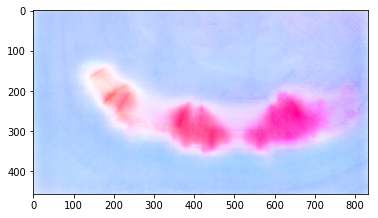

time: 350 ms


In [39]:
plt.imshow(flow_to_image(fh))

In [30]:
mLosses = np.array(mLosses)
sLosses = np.array(sLosses)
pLosses = np.array(pLosses)
asLosses = np.array(asLosses)
tLosses = pLosses + mLosses

time: 2.6 ms


max flow: 8.7021
flow range:
u = -4.448 .. 8.423
v = -6.787 .. 4.242


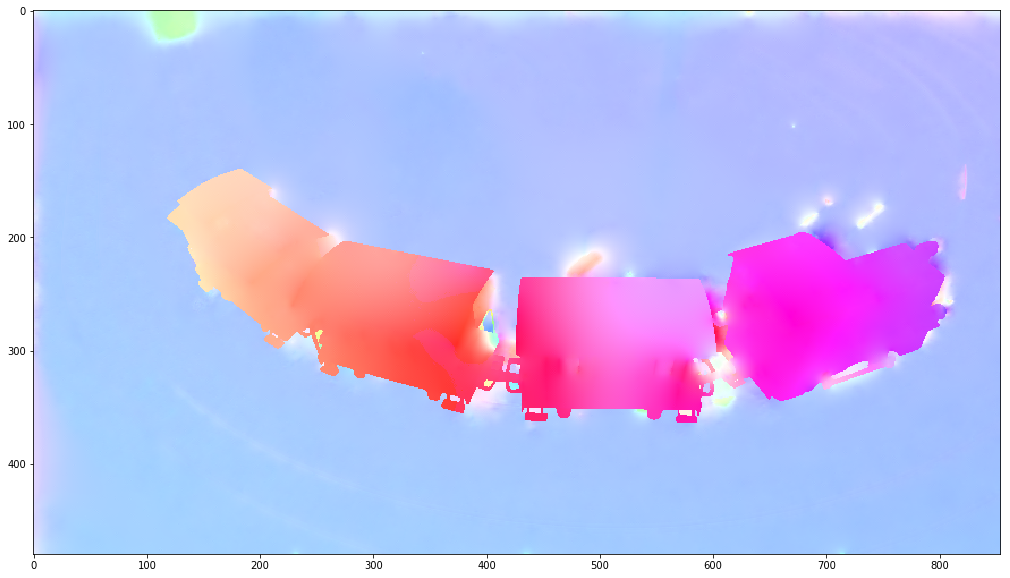

time: 675 ms


In [31]:
plt.figure(figsize=(20, 10))
plt.imshow(flow_to_image(flows[-1]))